In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CXX'] = 'g++'

In [3]:
import arviz
import numpy as np
import pymc3 as pm
from tqdm import tqdm

In [4]:
from IPython.display import display

In [5]:
import scipy.stats.distributions as dist

In [6]:
def get_quantile(density, bins, q):
    cumsums = np.cumsum(density * (bins[1:] - bins[:-1]))
    
    bin_index = np.nonzero(cumsums>=q)[0][0]
    # report center of bin
    return (bins[bin_index] + bins[bin_index+1]) * 0.5

In [7]:
def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)

def beta_params(mean, var):
    return {
        'alpha': beta_a(mean, var),
        'beta': beta_b(mean, var),
    }

In [8]:
# todo: beta prior for infection rate (compute with method of moments)
#       beta prior for infection fatality rate (mean=0.1, std>0.1)


# run models with weak priors and with priors that encode what we knew before.
# do sensitivity analysis for priors

# try beta prior over german infected rate and define infected as bernoulli
# compare with sampling negative binomial

# put into private github repo

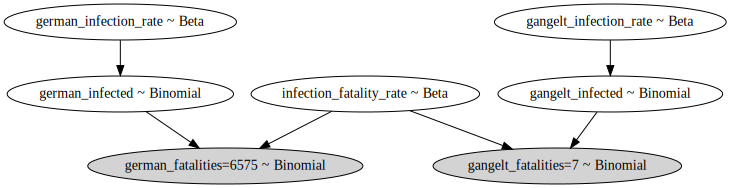

In [9]:
with pm.Model() as model:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    # while this is not perfect, here I model it as a normal distribution
    #infection_rate = pm.Normal(mu=0.1553, sd=(0.1896-0.1231)/4, name='infection_rate')
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)
    
    # we assume a reasonably located and quite uniformative infection rate for germany
    german_infection_rate = pm.Beta(**beta_params(mean=0.1, var=0.2**2), name='german_infection_rate')
    total_germany = 80000000
    german_infected = pm.Binomial(n=total_germany, p=german_infection_rate, name='german_infected')
    german_fatalities = pm.Binomial(n=german_infected, p=infection_fatality_rate, observed=6575, name='german_fatalities=6575')
    
    display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors

let's have a look into the priors to see whether they align with our intuitions and are not too narrow

In [10]:
with model:
    prior = pm.sample_prior_predictive(samples=50000)

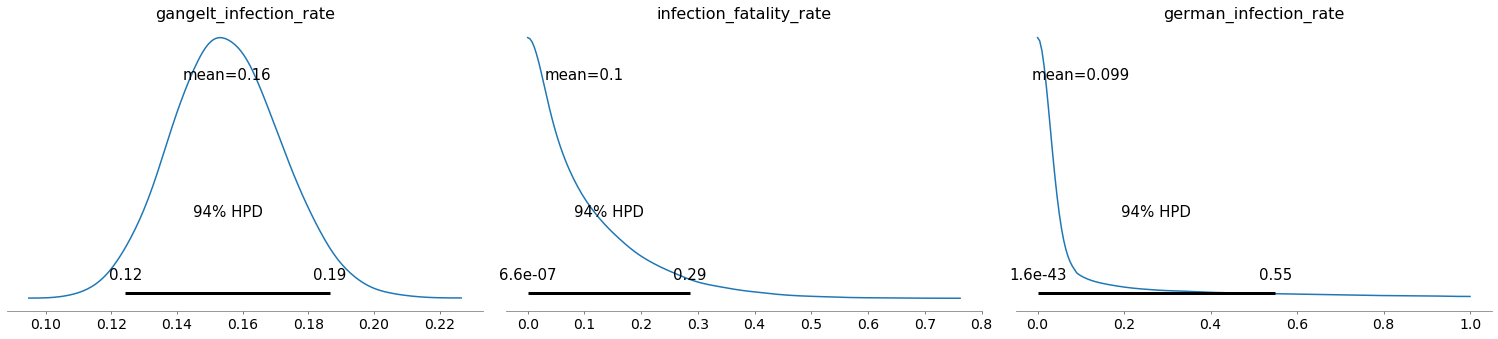

In [11]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
    'german_infection_rate'
]);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a967cc1d0>,
      dtype=object)

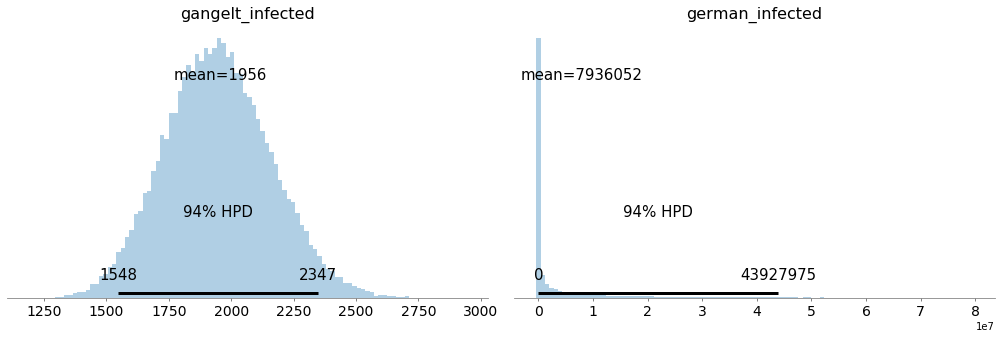

In [12]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infected',
    'german_infected'
], bins=100)

## Sampling the posterior

In [14]:
posterior = None

In [15]:
with model:
    posterior = pm.sample(draws=100000, trace=posterior)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [german_infection_rate, infection_fatality_rate, gangelt_infection_rate]
>CompoundStep
>>Metropolis: [german_infected]
>>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [03:21<00:00, 1991.50draws/s]
The acceptance probability does not match the target. It is 0.6763506224053474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5592241056992902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.624148666585238, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [46]:
pm.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gangelt_infected,2034.002,221.035,1613.000,2443.000,26.817,19.045,68.0,68.0,67.0,192.0,1.03
german_infected,5198070.948,2421105.729,1066786.000,8449172.000,1050769.009,788139.434,5.0,5.0,6.0,29.0,1.84
gangelt_infection_rate,0.161,0.017,0.129,0.194,0.002,0.001,70.0,70.0,69.0,202.0,1.03
infection_fatality_rate,0.002,0.002,0.001,0.005,0.001,0.000,6.0,6.0,6.0,29.0,1.84
german_infection_rate,0.065,0.030,0.013,0.106,0.013,0.010,5.0,5.0,6.0,29.0,1.84


As one can see, there are substantial problems in sampling. The number of effective samples is less than zero for the infection fatality rate, the german infection rate and the number of infections in Germany. Therefore the posterior won't tell use anything useful. Let's look at it anyway:

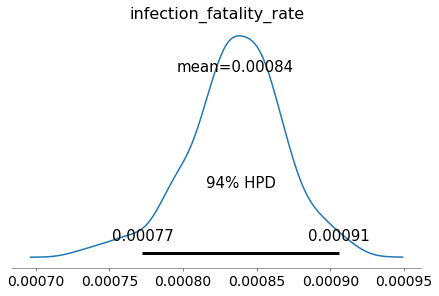

In [16]:
arviz.plot_posterior(posterior, var_names=[
    'infection_fatality_rate'
], bins=100);

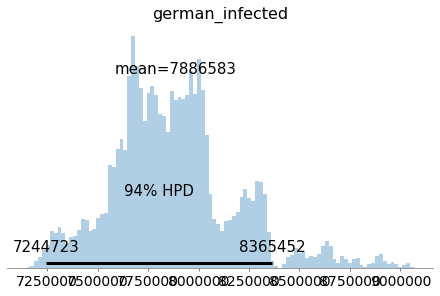

In [17]:
arviz.plot_posterior(posterior, var_names=[
    'german_infected'
], bins=100);